# Проект: Прогнозирование оттока клиентов банка

## Данные

В наличии были следующие данные:  
  
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
- Exited — факт ухода клиента

## Задача

На основе данных из банка определить клиентa, который может уйти.


## Используемые библиотеки

pandas, numpy, os, matplotlib, sklearn

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier


from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

In [2]:
import os
path = '/datasets/Churn.csv'
if not os.path.exists(path):
    path = 'DataFrames/Churn.csv'
    
data = pd.read_csv(path)

In [69]:
print(data.dtypes) # Типы признаков 
display(data.head()) 

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [70]:
data['Geography'] = pd.get_dummies(data['Geography'], drop_first=True) # Кодирование котегориальной переменной техникой One-Hot Encoding

In [71]:
data['Gender'] = pd.get_dummies(data['Gender'],  drop_first=True) # Кодирование котегориальной переменной техникой One-Hot Encoding

In [72]:
print(data.dtypes) # Типы признаков 
display(data.head()) 

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography            uint8
Gender               uint8
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,0,0,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,0,0,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,0,0,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,0,0,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,0,0,43,2.0,125510.82,1,1,1,79084.10,0


In [73]:
data.isna().sum() # Поиск и подсчет пропусков

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [74]:
data['Tenure'] = data['Tenure'].fillna(0)

In [75]:
data.duplicated().sum() # Поиск подсчет явных дубликатов

0

array([[<AxesSubplot:title={'center':'RowNumber'}>,
        <AxesSubplot:title={'center':'CustomerId'}>,
        <AxesSubplot:title={'center':'CreditScore'}>,
        <AxesSubplot:title={'center':'Geography'}>],
       [<AxesSubplot:title={'center':'Gender'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Tenure'}>,
        <AxesSubplot:title={'center':'Balance'}>],
       [<AxesSubplot:title={'center':'NumOfProducts'}>,
        <AxesSubplot:title={'center':'HasCrCard'}>,
        <AxesSubplot:title={'center':'IsActiveMember'}>,
        <AxesSubplot:title={'center':'EstimatedSalary'}>],
       [<AxesSubplot:title={'center':'Exited'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

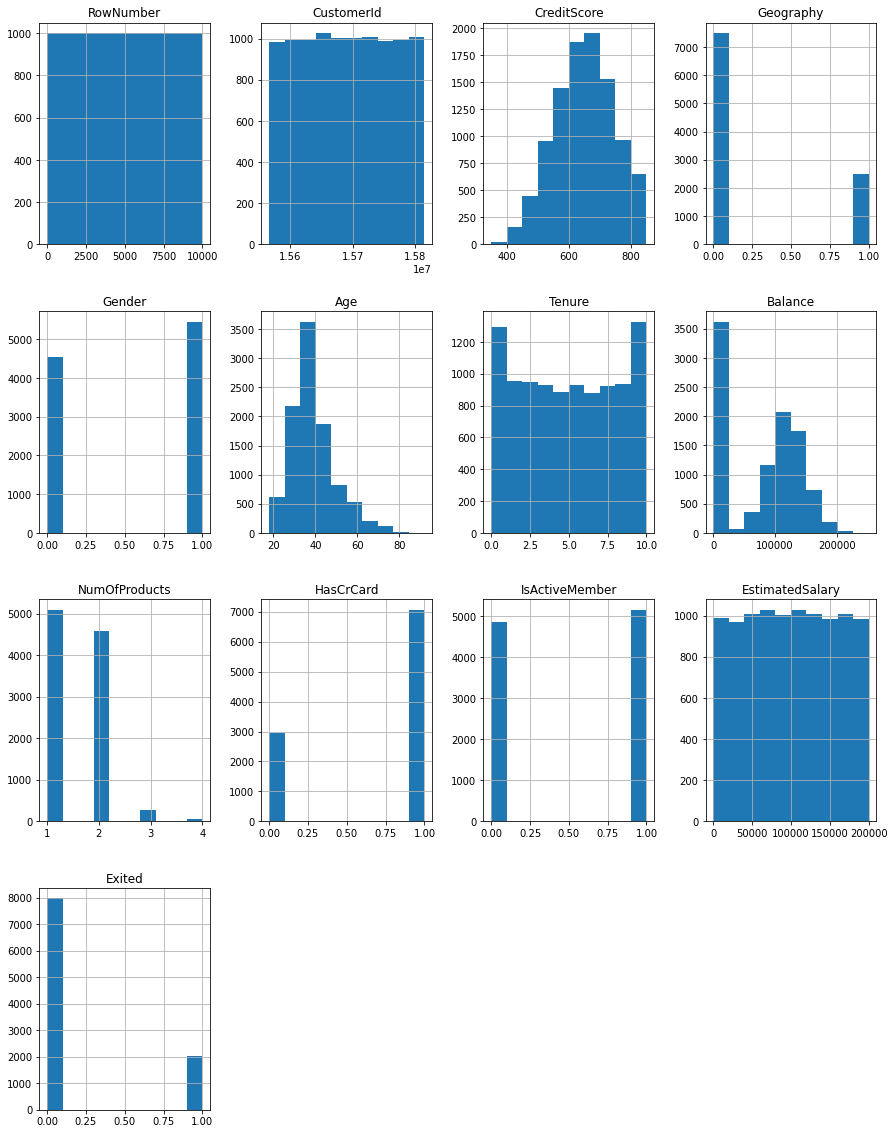

In [76]:
data.hist(figsize=(15, 20)) # Проверка наличия неадекватных значений

## Исследование задачи

In [77]:
data.groupby('Exited')['Exited'].count() 

Exited
0    7963
1    2037
Name: Exited, dtype: int64

Данные несбалансированны

In [78]:
data_train, data_valid_test = train_test_split(data, test_size=0.4, random_state=12345)
data_valid, data_test = train_test_split(data_valid_test, test_size=0.5, random_state=12345)

features_train = data_train.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
target_train = data_train['Exited']
features_valid = data_valid.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
target_valid = data_valid['Exited']

In [79]:
# Дерево решений
for depth in range(1,10):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train,target_train)
    predictions_valid = model_tree.predict(features_valid)
    print('max_depth =',depth,': ', end='')
    print(accuracy_score(target_valid, predictions_valid))

max_depth = 1 : 0.791
max_depth = 2 : 0.824
max_depth = 3 : 0.838
max_depth = 4 : 0.852
max_depth = 5 : 0.853
max_depth = 6 : 0.8565
max_depth = 7 : 0.8515
max_depth = 8 : 0.8495
max_depth = 9 : 0.8485


Оптимальная глубина 6.

In [80]:
# Случайный лес
for est in range(2, 40, 5):
    model_forest = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model_forest.fit(features_train, target_train)
    result = model_forest.score(features_valid, target_valid)
    print("Accuracy:",result,'est:',est)

Accuracy: 0.812 est: 2
Accuracy: 0.838 est: 7
Accuracy: 0.8465 est: 12
Accuracy: 0.853 est: 17
Accuracy: 0.854 est: 22
Accuracy: 0.8555 est: 27
Accuracy: 0.854 est: 32
Accuracy: 0.8565 est: 37


Оптимальное количество деревьев 27.

In [81]:
model_tree = DecisionTreeClassifier(random_state=12345, max_depth=6)
model_tree.fit(features_train,target_train)

model_forest = RandomForestClassifier(random_state=12345, n_estimators=27) 
model_forest.fit(features_train, target_train)

lists = [0]*len(target_valid)
pred_constant_tree = pd.Series(lists)
print(accuracy_score(target_valid, pred_constant_tree))

0.791


Mодели не прошли тест на адекватность. Значение accuracy_score при константной модели равно проценту значений 0 в столбце Exited. Дисбаланс необходимо устранить.

## Борьба с дисбалансом

Устранение дисбаланса взвешиванием классов.

In [82]:
# Дерево решений
for depth in range(1,10):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_tree.fit(features_train,target_train)
    predictions_valid = model_tree.predict(features_valid)
    print('max_depth =',depth,': ', end='')
    print("F1:",f1_score(target_valid, predictions_valid))

max_depth = 1 : F1: 0.4994903160040775
max_depth = 2 : F1: 0.541015625
max_depth = 3 : F1: 0.541015625
max_depth = 4 : F1: 0.5277777777777778
max_depth = 5 : F1: 0.5963791267305644
max_depth = 6 : F1: 0.5581835383159887
max_depth = 7 : F1: 0.5545545545545546
max_depth = 8 : F1: 0.5392156862745098
max_depth = 9 : F1: 0.5268199233716475


Оптимальная глубина 5.

In [83]:
# Случайный лес
for depth in range(2,20):
    model_forest = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=depth,  class_weight='balanced') 
    model_forest.fit(features_train, target_train)
    predictions_valid = model_forest.predict(features_valid)
    print("F1:",f1_score(target_valid, predictions_valid),'depth',depth)

F1: 0.5677655677655677 depth 2
F1: 0.5789473684210527 depth 3
F1: 0.5906838453914767 depth 4
F1: 0.5998013902681232 depth 5
F1: 0.6210418794688458 depth 6
F1: 0.6166666666666667 depth 7
F1: 0.6266375545851528 depth 8
F1: 0.6275862068965518 depth 9
F1: 0.6107784431137725 depth 10
F1: 0.6142131979695431 depth 11
F1: 0.6047120418848168 depth 12
F1: 0.5787348586810229 depth 13
F1: 0.5685997171145686 depth 14
F1: 0.5610465116279071 depth 15
F1: 0.5577211394302849 depth 16
F1: 0.5389221556886228 depth 17
F1: 0.5587786259541985 depth 18
F1: 0.5404580152671755 depth 19


Оптимальная глубина - 6. 

In [84]:
# Случайный лес
for est in range(2, 90, 5):
    model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=6, class_weight='balanced') 
    model_forest.fit(features_train, target_train)
    predictions_valid = model_forest.predict(features_valid)
    print("F1:",f1_score(target_valid, predictions_valid),'est:',est)

F1: 0.5312800769971125 est: 2
F1: 0.599375650364204 est: 7
F1: 0.6120777891504605 est: 12
F1: 0.6183673469387755 est: 17
F1: 0.6233230134158926 est: 22
F1: 0.6266804550155118 est: 27
F1: 0.6251276813074567 est: 32
F1: 0.6188524590163934 est: 37
F1: 0.6229508196721312 est: 42
F1: 0.618705035971223 est: 47
F1: 0.615702479338843 est: 52
F1: 0.6138002059732234 est: 57
F1: 0.6147540983606556 est: 62
F1: 0.6150712830957231 est: 67
F1: 0.616326530612245 est: 72
F1: 0.6167846309403437 est: 77
F1: 0.6164801627670397 est: 82
F1: 0.6182190378710338 est: 87


Оптимальное количество деревьев 27.

Устранение дисбаланса увеличением выборки.

In [85]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

<div class="alert alert-block alert-info"> отрицательный класс больше положительного в 7963/2037, то есть примерно в 4 раза</div>

In [86]:
# Дерево решений

model_tree = DecisionTreeClassifier(random_state=12345, max_depth=5)
model_tree.fit(features_upsampled, target_upsampled)
predictions_valid = model_tree.predict(features_valid)
print("F1:",f1_score(target_valid, predictions_valid))

F1: 0.5963791267305644


In [87]:
# Случайный лес

model_forest = RandomForestClassifier(random_state=12345, n_estimators=27)
model_forest.fit(features_upsampled, target_upsampled)
predictions_valid = model_forest.predict(features_valid)
print("F1:",f1_score(target_valid, predictions_valid))

F1: 0.5982028241335045


Устранение дисбаланса уменьшением выборки.

In [88]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

<div class="alert alert-block alert-info"> положительный класс меньше отрицательного в 2037/7963, то есть примерно в 0.25 раза</div>

In [89]:
# Дерево решений

model_tree = DecisionTreeClassifier(random_state=12345,  max_depth=5)
model_tree.fit(features_downsampled, target_downsampled)
predictions_valid = model_tree.predict(features_valid)
print("F1:",f1_score(target_valid, predictions_valid))

F1: 0.592292089249493


In [90]:
# Случайный лес

model_forest = RandomForestClassifier(random_state=12345, n_estimators=27)
model_forest.fit(features_downsampled, target_downsampled)
predictions_valid = model_forest.predict(features_valid)
print("F1:",f1_score(target_valid, predictions_valid))

F1: 0.5751633986928104


Сравнивая F1 приходим к выводу, что устранение дисбаланса взвешиванием классов оказалось наиболее эффективным. Наилучшая модель - случайный лес с количеством деревьев 27, их глубиной 6.

## Тестирование модели

In [91]:
features_test = data_test.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
target_test = data_test['Exited']

model_forest = RandomForestClassifier(random_state=12345, n_estimators=27, max_depth=6, class_weight='balanced') 
model_forest.fit(features_test, target_test)
predictions_test = model_forest.predict(features_test)
print("F1:",f1_score(target_test, predictions_test))

F1: 0.7136929460580913


In [92]:
probabilities_test = model_forest.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(auc_roc)

0.9235913418511672


auc_roc показывает насколько модель отличается от случайной. auc_roc больше F1.

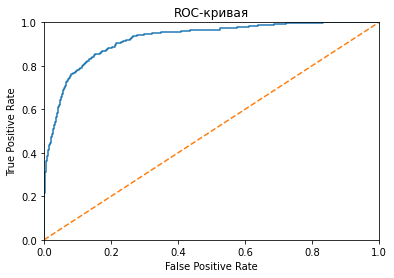

In [93]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()


<b>Вывод:</b>
<div class="alert alert-block alert-info">Изучены типы данных, заполнены пропуски в столбце Tenure, закодировали категориальные переменные техникой One-Hot Encoding, устранен дисбаланс данных, найдена лучшая модель - случайный лес с количеством деревьев 27, их глубиной 6.
Рассчитаны F1-мера = 0,7137 и auc_roc = 0,9236, которые показывают, что модель делает хорошую работу, и для многих других значений порога она будет делать то же самое.</div>
